# Fine-Tuning de um Modelo Transformer para Classificação de Sentimento

## Bibliotecas usadas

In [1]:
#!pip install -q numpy==1.26.2
#!pip install -q keras
#!pip install -q spacy
#!pip install -q tensorflow
#!pip install -q keras-preprocessing

In [2]:
# Imports
import math
import nltk
import spacy
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import transformers
from tokenizers import BertWordPieceTokenizer
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.metrics import Precision, Recall, AUC
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, LearningRateScheduler, CallbackList, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

2025-12-31 11:22:19.379805: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-31 11:22:19.380518: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-31 11:22:19.383331: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-31 11:22:19.391312: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767190939.404940   29678 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767190939.40

## Dados

Dados extraidos da platoforma hugging face

https://huggingface.co/datasets/carblacac/twitter-sentiment-analysis

In [3]:
dados_treino = pd.read_csv('/home/priscila/Downloads/03-DeepL/dados/dados_treino_p2.txt', header= None, delimiter=';')
dados_treino.head()

,0,1
0,i am feeling completely overwhelmed i have two...,fear
1,i have the feeling she was amused and delighted,joy
2,i was able to help chai lifeline with your sup...,joy
3,i already feel like i fucked up though because...,anger
4,i still love my so and wish the best for him i...,sadness


In [4]:
dados_teste = pd.read_csv('/home/priscila/Downloads/03-DeepL/dados/dados_teste_p2.txt', header= None, delimiter=';')
dados_teste.head()

,0,1
0,i feel like my only role now would be to tear ...,sadness
1,i feel just bcoz a fight we get mad to each ot...,anger
2,i feel like reds and purples are just so rich ...,joy
3,im not sure the feeling of loss will ever go a...,sadness
4,i feel like ive gotten to know many of you thr...,joy


In [5]:
dados_treino = dados_treino.rename(columns={0: 'texto', 1: 'sentimento'})
dados_teste = dados_teste.rename(columns={0: 'texto', 1: 'sentimento'})

In [6]:
print(dados_treino.shape)
print(dados_teste.shape)

(16000, 2)
(2000, 2)


In [7]:
dados_treino['sentimento'].value_counts()

sentimento
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [8]:
dados_teste['sentimento'].value_counts()

sentimento
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

obs: importante que a saída dos dados de treino e teste sejam a mesma.

## Pré-processamento de dados de texto com spacy

In [9]:
#Restart kernel
#import IPython
#IPython.Application.instance().kernel.do_shutdown(True)


In [10]:
#!python -m pip install spacy -q
#!python -m spacy download en_core_web_md
#%pip install -U spacy
%pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_md-3.8.0/en_core_web_md-3.8.0-py3-none-any.whl

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 10.2 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [11]:
nlp = spacy.load('en_core_web_md')

In [12]:
text = "Machine learning is the ability of a machine to improve its performance on a specific task"
doc = nlp(text)
type(doc)

spacy.tokens.doc.Doc

In [13]:
for token in doc:
    print(token.text, "-",token.pos_,"-" ,token.lemma_, "-", token.is_stop)


Machine - NOUN - machine - False
learning - NOUN - learning - False
is - AUX - be - True
the - DET - the - True
ability - NOUN - ability - False
of - ADP - of - True
a - DET - a - True
machine - NOUN - machine - False
to - PART - to - True
improve - VERB - improve - False
its - PRON - its - True
performance - NOUN - performance - False
on - ADP - on - True
a - DET - a - True
specific - ADJ - specific - False
task - NOUN - task - False


In [14]:
## Função para pré-processamento de texto
def pre_process(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower().strip() for token in doc if not token.is_stop]
    return ' '.join(tokens)

In [15]:
pre_process(text)

'machine learning ability machine improve performance specific task'

In [16]:
dados_treino['texto_processado'] = dados_treino['texto'].apply(pre_process)

In [17]:
dados_teste['texto_processado'] = dados_teste['texto'].apply(pre_process)

In [18]:
dados_treino.head(1)

,texto,sentimento,texto_processado
0,i am feeling completely overwhelmed i have two...,fear,feel completely overwhelmed strategy help feel...


In [19]:
dados_treino.shape

(16000, 3)

A função `pre_process` recebeu um texto bruto e realizou um pré-processamento clássico de NLP usando o spaCy, transformando o texto em uma versão padronizada e mais adequada para análises posteriores. Primeiro, o texto é processado pelo pipeline nlp, que tokeniza e analisa linguisticamente o conteúdo. Em seguida, a função percorre cada token, remove palavras irrelevantes (stopwords), converte cada termo para sua forma base (lematização), padroniza para letras minúsculas e elimina espaços extras. Por fim, os tokens processados são reunidos novamente em uma única string, separada por espaços, resultando em um texto limpo, normalizado e menos ruidoso, apropriado para tarefas como vetorização, classificação ou análise exploratória de textos.

## Modelo 1 - Arquitetura Fully Connect Neural Network

## 1. Vetorização com TF-IDF

In [20]:
tf_idf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

Esta linha acima cria uma instância do `TfidfVectorizer` da biblioteca scikit-learn, que é uma ferramenta utilizada para converter uma coleção de documentos brutos em uma matriz de recursos TF-IDF (Term Frequency-Inverse Document Frequency). O TF-IDF é uma técnica estatística usada para quantificar a importância de uma palavra em um conjunto de documentos, comumente utilizada em tarefas de processamento de linguagem natural e recuperação de informações.

**Parâmetro max_df=0.95**: Este parâmetro define o limite máximo de frequência de documento para os termos que serão considerados. Aqui, está definido como 0.95, o que significa que palavras que aparecem em mais de 95% dos documentos serão ignoradas. Isso ajuda a eliminar palavras comuns que não contribuem muito para o significado do texto.

**Parâmetro min_df=2**: Este parâmetro estabelece a frequência mínima de documento para os termos. Neste caso, termos que aparecem em menos de 2 documentos serão ignorados. Isso ajuda a filtrar termos raros que podem ocorrer apenas em poucas amostras e, portanto, são menos relevantes para a análise geral.

**Parâmetro stop_words='english'**: Este parâmetro instrui o vetorizador a remover todas as palavras de parada em inglês da análise. Palavras de parada são palavras comuns (como "e", "o", "em") que geralmente são filtradas em processamento de linguagem natural porque são muito frequentes e não carregam informações significativas para a análise de texto.

In [21]:
#Aplica a vetorização
dados_treino_tfidf = tf_idf.fit_transform(dados_treino['texto_processado'])
dados_treino_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 112822 stored elements and shape (16000, 5593)>

o objeto tf_idf aprende o vocabulário a partir dos textos de treino. Ele identifica todas as palavras que aparecem, calcula com que frequência cada palavra ocorre em cada documento (TF) e o quão rara ou comum ela é no conjunto inteiro (IDF). Ao mesmo tempo, ele já transforma cada texto em um vetor numérico, onde cada posição representa uma palavra do vocabulário e o valor indica sua importância naquele texto. Esse aprendizado só é feito nos dados de treino para evitar vazamento de informação.

In [22]:
dados_teste_tfidf = tf_idf.transform(dados_teste['texto_processado'])
dados_teste_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 13651 stored elements and shape (2000, 5593)>

o modelo não aprende nada novo. Ele apenas usa o vocabulário e os pesos aprendidos no treino para transformar os textos de teste em vetores numéricos compatíveis. Palavras que não existiam no treino são ignoradas, garantindo que os dados de treino e teste fiquem no mesmo espaço vetorial.

In [23]:
dados_treino_tfidf.shape

(16000, 5593)

In [24]:
dados_teste_tfidf.shape

(2000, 5593)

In [25]:
# Visualizando as features criadas pela vetorização TF-IDF
feature_names = tf_idf.get_feature_names_out()

df_tfidf = pd.DataFrame(
    dados_treino_tfidf[:5].toarray(),  # só os 5 primeiros textos
    columns=feature_names
)

print(df_tfidf.columns)


Index(['aa', 'abandon', 'abandonment', 'abc', 'abdomen', 'abide', 'ability',
       'abit', 'able', 'abroad',
       ...
       'yuuki', 'zach', 'zealand', 'zen', 'zero', 'zest', 'zombie', 'zone',
       'zoom', 'zumba'],
      dtype='object', length=5593)


In [26]:
df_tfidf

,aa,abandon,abandonment,abc,abdomen,abide,ability,abit,able,abroad,...,yuuki,zach,zealand,zen,zero,zest,zombie,zone,zoom,zumba
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.490603,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Trasformar os dados de entrada (texto) para array:

In [27]:
X_treino_array = dados_treino_tfidf.toarray()
X_teste_array = dados_teste_tfidf.toarray()

In [29]:
print(X_treino_array)
X_teste_array.shape

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(2000, 5593)

Os dados foram vetorizados

### 2. Preparação dos dados

Converter a variavel alvo para representação numérica.

In [30]:
encoder = LabelEncoder()

In [31]:
# Faz o fit e transform na variável alvo em treino
y_treino_le = encoder.fit_transform(dados_treino['sentimento'])
print(np.unique(y_treino_le))

[0 1 2 3 4 5]


In [32]:
y_teste_le = encoder.transform(dados_teste['sentimento'])
print(np.unique(y_teste_le))

[0 1 2 3 4 5]


Tratar o desbalanceamento de classes dando pesos menores para classes com menos dados.

In [33]:
# Peso das classes
pesos_classes = compute_class_weight('balanced', classes = np.unique(y_treino_le), y = y_treino_le)

**compute_class_weight**: Esta é uma função do scikit-learn que calcula os pesos para as classes. Esses pesos podem ser usados em modelos de classificação para dar mais importância a classes que são sub-representadas no conjunto de dados.

**'balanced'**: Este parâmetro indica que os pesos das classes devem ser calculados de forma que equilibrem o conjunto de dados. Isso é feito inversamente proporcional à frequência das classes no conjunto de dados. Classes mais frequentes recebem um peso menor, enquanto classes menos frequentes recebem um peso maior.

**classes = np.unique(y_treino_le)**: Aqui, np.unique(y_treino_le) encontra todas as classes únicas no conjunto de dados de treinamento. O parâmetro classes informa à função compute_class_weight quais são essas classes únicas.

**y = y_treino_le**: Este é o vetor de rótulos do conjunto de dados de treinamento. A função usará esses rótulos para calcular a frequência de cada classe.

O resultado, armazenado em pesos_classes, é um array onde cada classe tem um peso associado. Esses pesos podem ser usados em modelos de classificação (como uma árvore de decisão, um modelo de regressão logística, SVM, etc.) para compensar o desequilíbrio entre as classes.

In [34]:
# Divisão em Dados de Treino e Teste (validação)
X_treino, X_val, y_treino, y_val = train_test_split(X_treino_array, 
                                                    y_treino_le, 
                                                    test_size = 0.2, 
                                                    random_state = 42, 
                                                    stratify = y_treino_le)

In [35]:
# Ajusta a variável alvo como tipo categórico
y_treino_encoded = to_categorical(y_treino)
y_teste_encoded = to_categorical(y_teste_le)
y_val_encoded = to_categorical(y_val)

### 3. Construção do modelo

In [36]:
# Inicializa um modelo sequencial. Modelos sequenciais são uma pilha linear de camadas.
modelo1 = Sequential() 

# Adiciona a primeira camada densa (fully-connected) ao modelo
modelo1.add(Dense(4096, # número de neurônios na camada
                        
                        # Utiliza a função de ativação SELU (Scaled Exponential Linear Unit)
                        activation = 'selu',  
                        
                        # Inicializa os pesos com a distribuição LeCun normal
                        kernel_initializer = 'lecun_normal',  
                        
                        # Define o formato da entrada com base no número de features do X_treino
                        input_shape = (X_treino.shape[1],),  
                        
                        # Aplica regularização L2 para reduzir o overfitting
                        kernel_regularizer = tf.keras.regularizers.l2(0.01)))  

# Adiciona a segunda camada densa
modelo1.add(Dense(2048, 
                        activation = 'selu',  
                        kernel_initializer = 'lecun_normal',  
                        kernel_regularizer = tf.keras.regularizers.l2(0.01)))  

# Adiciona a terceira camada densa
modelo1.add(Dense(1024, 
                        activation = 'selu',  
                        kernel_initializer = 'lecun_normal',  
                        kernel_regularizer = tf.keras.regularizers.l2(0.1)))  

# Adiciona a quarta camada densa
# Camada com 64 neurônios e ativação SELU
modelo1.add(Dense(64, activation = 'selu',))  

# Adiciona a camada de saída
# Camada de saída com 6 neurônios e ativação softmax para classificação multiclasse
modelo1.add(Dense(6, activation = 'softmax'))  

2025-12-31 11:25:33.282250: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### 4 - Compilação e sumário do modelo

In [37]:
# Atribui pesos específicos ao vetor de bias da última camada do modelo
modelo1.layers[-1].bias.assign(pesos_classes)

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([1.2351397 , 1.3766993 , 0.49732688, 2.0449898 , 0.5715102 ,
       4.6620045 ], dtype=float32)>

In [38]:
# Compila o modelo
modelo1.compile(optimizer = 'Adam',  # Define o otimizador como 'Adam'. 
                      loss = tf.losses.categorical_crossentropy,  
                      metrics = ['accuracy'])  

 **Adam** é um algoritmo de otimização que pode ser usado no lugar do procedimento clássico de descida 
do gradiente estocástica para atualizar os pesos da rede iterativamente com base nos dados de treinamento.
Define a função de perda como 'categorical_crossentropy'. É adequada para problemas de classificação 
multiclasse, onde os rótulos são fornecidos em um formato one-hot encoded.
Define a métrica de avaliação do modelo como 'accuracy' (acurácia). 
A acurácia é uma métrica comum para avaliar o desempenho de modelos de classificação.

In [39]:
modelo1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 4096)           │    22,913,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,467,846 (127.67 MB)

 Trainable params: 33,467,846 (127.67 MB)

 Non-trainable params: 0 (0.00 B)

### 5: Callbacks e Earlystop

In [40]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    return lrate

In [41]:
# Agendador de Taxa de Aprendizado
lr_scheduler = LearningRateScheduler(step_decay)

In [42]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights = True, patience = 3) 

### 6: Treinamento do modelo

In [43]:
num_epochs = 20
tamanho_batch = 256

In [44]:
history = modelo1.fit(X_treino, 
                      y_treino_encoded, 
                      validation_data = (X_val, y_val_encoded), 
                      epochs = num_epochs, 
                      batch_size = tamanho_batch, 
                      callbacks = [early_stopping, lr_scheduler])

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 542ms/step - accuracy: 0.5319 - loss: 77.5811 - val_accuracy: 0.7950 - val_loss: 2.2809 - learning_rate: 0.0010
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 556ms/step - accuracy: 0.8140 - loss: 1.6809 - val_accuracy: 0.7903 - val_loss: 1.3482 - learning_rate: 0.0010
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 555ms/step - accuracy: 0.8452 - loss: 1.1737 - val_accuracy: 0.7872 - val_loss: 1.2782 - learning_rate: 0.0010
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 545ms/step - accuracy: 0.8751 - loss: 1.0470 - val_accuracy: 0.8225 - val_loss: 1.1308 - learning_rate: 0.0010
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 546ms/step - accuracy: 0.8931 - loss: 0.9244 - val_accuracy: 0.8153 - val_loss: 1.1335 - learning_rate: 0.0010
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 570ms/step - accuracy: 0.9099 - loss: 0.8916 - val_accuracy: 0.8359 - val_loss: 1.1124 - learning_rate: 0.0010
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 560ms/step - accuracy: 0.9220 - loss: 0

### 7. Avaliação do modelo

In [45]:
loss, val_loss = history.history['loss'], history.history['val_loss']

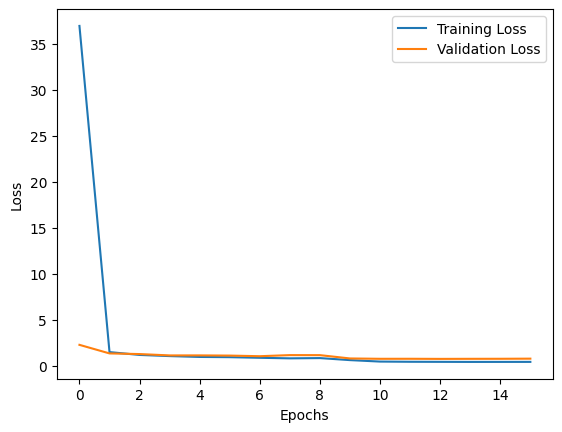

In [46]:
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
# Extrai previsões do modelo
previsoes1 = modelo1.predict(X_teste_array)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [49]:
previsoes1_labels = previsoes1.argmax(axis = 1)

In [53]:
print("Acurácia:", accuracy_score(y_teste_le, previsoes1_labels))

Acurácia: 0.8435


In [50]:
print(classification_report(y_teste_le, previsoes1_labels))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       275
           1       0.82      0.80      0.81       224
           2       0.91      0.85      0.88       695
           3       0.63      0.80      0.70       159
           4       0.87      0.88      0.87       581
           5       0.70      0.71      0.71        66

    accuracy                           0.84      2000
   macro avg       0.80      0.81      0.80      2000
weighted avg       0.85      0.84      0.85      2000



In [51]:
print("Matriz de confusão:")
print(confusion_matrix(y_teste_le, previsoes1_labels))

Matriz de confusão:
[[230  10   7   5  23   0]
 [ 10 179   6   0  18  11]
 [  9   3 590  53  31   9]
 [  1   2  22 127   7   0]
 [ 20  16  16  15 514   0]
 [  1   8   7   2   1  47]]


In [54]:
# Salva o modelo
modelo1.save('modelo_v1.keras')  

### 8. Deploy do modelo

In [56]:
modelo_v1 = load_model('modelo_v1.keras')

In [108]:
nova_frase = "it's a new life and i'm feeling good"

In [109]:
# Cria um dataframe com a frase
df_novo = pd.DataFrame({'Frase': [nova_frase]})
# Aplica a função de processamento
df_novo['Frase_Processada'] = df_novo['Frase'].apply(pre_process)
df_novo

,Frase,Frase_Processada
0,it's a new life and i'm feeling good,new life feel good


In [110]:
# Aplica a vetorização
df_novo_tfidf = tf_idf.transform(df_novo['Frase_Processada'])

# Transforma em array
df_novo_array = df_novo_tfidf.toarray()

In [111]:
previsoes_prob = modelo_v1.predict(df_novo_array)
previsoes_prob

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


array([[0.00937178, 0.03071205, 0.6725753 , 0.04538173, 0.2222482 ,
        0.01971091]], dtype=float32)

In [112]:
maior_prob_class = np.argmax(previsoes_prob, axis=1)
maior_prob_class


array([2])

In [113]:
nome_classe = encoder.inverse_transform(maior_prob_class)
nome_classe

array(['joy'], dtype=object)